<a href="https://colab.research.google.com/github/pnpsuM/SOC_LSTM/blob/colab/SOC_LSTM_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import tensorflow as tf 
from tensorflow import keras
from keras import models, layers
import keras.optimizers as op
from keras.callbacks import ModelCheckpoint

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/180801_RFB_510cy_006_DC.csv')
data = data.drop(['시험_시간(s)', '사이클_번호', '사이클_시간(s)', '단계_번호', '단계_시간(s)', '인덱스', '보조전압1(V)', '보조전압2(V)', '보조전압3(V)', '온도(\'C)', '전류_범위', 'OCP(V)', '파워(W)', '부하(Ohm)', '누적_용량(Ah)', '절대값_용량(Ah)'], axis = 1)
data_voltage = data.copy()
data_voltage = data_voltage.pop('전압(V)')

data rows = 262407
Index(['전류(A)', '전압(V)'], dtype='object')
x = (262407, 2)
y = (262407,)


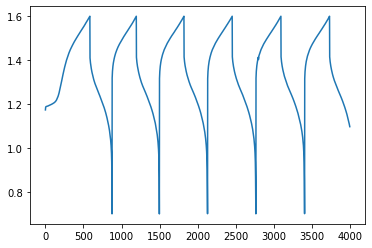

In [8]:
print(f'data rows = {data.shape[0]}')
print(data.columns)
data = data.values
print(f'x = {data.shape}')
print(f'y = {data_voltage.shape}')

# for index in range(data.shape[0]):
#     data[index, 0] = int(data[index, 0][3:5]) * 60 + int(data[index, 0][6:8])
#     data[index, 2] = int(data[index, 2][3:5]) * 60 + int(data[index, 2][6:8])
#     data[index, 4] = int(data[index, 4][3:5]) * 60 + int(data[index, 4][6:8])
pl.plot(data_voltage[:4000])

In [9]:
seq_len = 200
num_batch = int(np.floor(data.shape[0] / seq_len))
print(f'num_batch = {num_batch}')
x_data = []
y_data = []
for batch in range(num_batch):
    x_data.append(data[batch * seq_len:(batch + 1) * seq_len])
    y_data.append(data_voltage[batch * seq_len + 1:(batch + 1) * seq_len + 1])
x_data = np.array(x_data).astype(np.float32)
y_data = np.array(y_data).astype(np.float32)
print(f'x = {x_data.shape}')
print(f'y = {y_data.shape}')
print(x_data[0, 0:6, 1])
print(y_data[0, 0:5])

num_batch = 1312
x = (1312, 200, 2)
y = (1312, 200)
[1.173039  1.1802392 1.18315   1.184682  1.1857544 1.1868268]
[1.1802392 1.18315   1.184682  1.1857544 1.1868268]


In [10]:
split_len = int(round(num_batch * 0.75))
print(split_len)
x_train = x_data[:split_len]
y_train = y_data[:split_len]
x_test = x_data[split_len:]
y_test = y_data[split_len:]
print(y_train.shape)

## 데이터 전처리 끝

984
(984, 200)


In [12]:
loss_dict = {}
num_units = 256
num_epochs = 200
batch_size = 123
batch_index = 0
model = models.Sequential()
model.add(layers.LSTM(num_units, input_shape=(None, x_train.shape[2]), return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(num_units, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss = 'mse', optimizer = 'Adam')
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{seq_len}.h5', monitor = 'val_loss', save_best_only = True)]
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 256)         265216    
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_3 (LSTM)               (None, None, 256)         525312    
                                                                 
 dropout_3 (Dropout)         (None, None, 256)         0         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1)          257       
 tributed)                                                       
                                                                 
Total params: 790,785
Trainable params: 790,785
Non-trainable params: 0
________________________________________________

In [ ]:
batch_index += batch_size
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)
model.load_weights(f'Checkpoints\SOC_Checkpoint_{seq_len}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{batch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)
print(f'{num_units} units, {batch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [ ]:
batch_index += batch_size
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)
model.load_weights(f'Checkpoints\SOC_Checkpoint_{seq_len}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{batch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)
print(f'{num_units} units, {batch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [ ]:
batch_index += batch_size
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)
model.load_weights(f'Checkpoints\SOC_Checkpoint_{seq_len}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{batch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)
print(f'{num_units} units, {batch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [ ]:
batch_index += batch_size
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)
model.load_weights(f'Checkpoints\SOC_Checkpoint_{seq_len}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{batch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)
print(f'{num_units} units, {batch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [ ]:
batch_index += batch_size
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)
model.load_weights(f'Checkpoints\SOC_Checkpoint_{seq_len}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{batch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)
print(f'{num_units} units, {batch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])
print(loss_dict)